In [1]:
"""
    clustering.ipynb
    Functions for implementing k-means clustering for quantizing the colors in an image.
    Mustafa Siddiqui
"""
pass

In [2]:
from inc import IP
%matplotlib inline

In [3]:
def quantizeColors(img, numColors):
    ''' Quantize image into given number of colors using k-means 
        clustering algorithm.
    '''
    
    #red = img[:, :, 0].flatten()
    #blue = img[:, :, 1].flatten()
    #green = img[:, :, 2].flatten()
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]
    
    return red, green, blue

In [26]:
I = IP.imread('Doyley.jpg')
IGray = IP.rgb2gray(I);
l, w = IGray.shape

In [6]:
r, g, b = quantizeColors(I, 3)
#r = IP.np.reshape(r, (l, w))
#g = IP.np.reshape(g, (l, w))
#b = IP.np.reshape(b, (l, w))

In [7]:
out = IP.np.zeros((l, w, 3), dtype='int')
out[:,:,0] = r
out[:,:,1] = g
out[:,:,2] = b

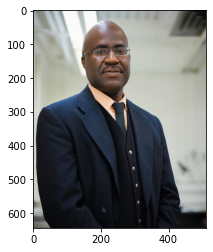

In [8]:
IP.imshow(out)

(644, 512, 3)

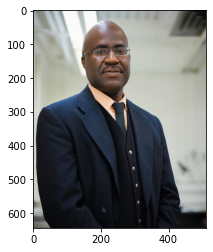

In [9]:
I2 = IP.imread('Doyley.jpg')
IP.imshow(I2)
I2.shape

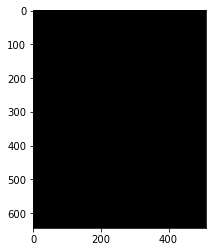

In [10]:
IP.imshow(I2-out, cmap='gray')

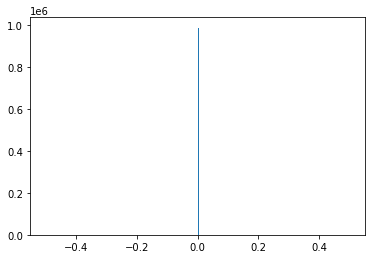

In [11]:
# confirm both images are exactly the same
dump = IP.plt.hist((I2-out).ravel(), bins=250)

In [12]:
class Color:
    ''' A class to store RGB values of a color and provide
        some simple methods.
    '''
    
    def __init__(self, red, green, blue):
        ''' Constructor for class. '''
        self.red = red
        self.green = green
        self.blue = blue
    
    def getDistance(self, anotherColor):
        ''' Returns the Euclidean distance on the RGB color cube model. '''
        redDiff = (self.red - anotherColor.red)**2
        greenDiff = (self.green - anotherColor.green)**2
        blueDiff = (self.blue - anotherColor.blue)**2
        
        return int(IP.np.sqrt(redDiff + blueDiff + greenDiff))
    
    def __str__(self):
        return "red: " + str(self.red) + ", green: " + str(self.green) + ", blue: " + str(self.blue)

In [13]:
def getColorFromPixel(img, coor):
    ''' Given a tuple of x,y coordinates (x, y), return the RGB values
        of the pixel at those coordinates in an image.
    '''
    
    red = int(img[coor[0], coor[1], 0])
    green = int(img[coor[0], coor[1], 1])
    blue = int(img[coor[0], coor[1], 2])
    
    return Color(red, green, blue)

In [14]:
def colorDistinctOrNot(color1, color2):
    ''' Helper function to check if two colors are distinct
        enough based on their euclidean distance on the RGB cube.
    '''
    
    d = color1.getDistance(color2)
    if (d > 50):
        return True
    
    return False

In [15]:
def chooseRandomColors(img, k):
    ''' Choose k random but distinct colors from the image.
        
        @return a set of k color objects
    '''
    l, w, numColors = img.shape
    
    # choose k distinct somewhat contrasting colors at random
    # first get random pixel coordinates and then obtain color
    colors = set()
    for i in range(k):
        x = IP.np.random.randint(1, l)
        y = IP.np.random.randint(1, w)
        coor = (x, y)
        color = getColorFromPixel(I, coor)
        
        distinct = False;
        while (distinct == False):
            x = IP.np.random.randint(1, l)
            y = IP.np.random.randint(1, w)
            coor = (x, y)
            color = getColorFromPixel(I, coor)
            
            # if set is not empty, check if new color is
            # somewhat distinct from colors already in set
            _distinct = True
            if (len(colors) != 0):
                for c in colors:
                    if (colorDistinctOrNot(c, color) == False):
                        # if not distinct with one, no need to check with others
                        _distinct = False
                        break

                # distinct from all colors currently stored
                if (_distinct):
                    distinct = True
            else:
                break
            
            # if color not distinct, pick another color
            if (distinct == False):
                continue
        
        # add distinct color
        colors.add(color)
        
    return colors

In [16]:
def getMinKey(distances):
    ''' Takes in a hashmap with Color object as key and the distance 
        on the RGB cube with a pixel (pre-calculated) as the value and
        returns the key (Color object) with the minimum distance.
        
        @return Color object
    '''
    
    # get centroid which has the lowest distance (aka color difference)
    minDiff = 9999
    minKey = Color(0,0,0)
    for key in distances:
        if distances[key] < minDiff:
            minDiff = distances[key]
            minKey = key
            
    return minKey

In [17]:
# get k random colors from image
k = 8
colorsCentroid = chooseRandomColors(I, k)
centroidList = list(colorsCentroid)

In [18]:
# create hashmap with centroids as keys and empty lists
# list for a centroid will store the colors which have the minimum difference
# with that centroid
centroidDict = {}
for c in centroidList:
    print(c)
    centroidDict[c] = []

red: 27, green: 35, blue: 48
red: 93, green: 94, blue: 86
red: 51, green: 75, blue: 113
red: 147, green: 117, blue: 117
red: 174, green: 193, blue: 197
red: 161, green: 164, blue: 157
red: 96, green: 65, blue: 44
red: 4, green: 4, blue: 6


In [19]:
changeInCentroids = True
while (changeInCentroids):
    # iterate over the image and populate centroid dictionary
    for i in range(l):
        for j in range(w):
            # get color from pixel
            pixelColor = getColorFromPixel(I, (i, j))
            
            # populate hashmap with distances between colors based on RGB cube
            distances = {}
            for centroid in centroidDict:
                if (centroid not in distances):
                    distances[centroid] = pixelColor.getDistance(centroid)
            
            # get centroid which has the lowest distance (aka color difference)
            minKey = getMinKey(distances)
            
            # add RGB color to centroid list
            centroidDict[minKey].append(pixelColor)
            
    # get mean of red, green, blue values separately and create new
    # color object with those values and update centroid values
    redSum = 0
    greenSum = 0
    blueSum = 0
    newDict = {}
    changeInCentroids = False
    for key in centroidDict:
        for color in centroidDict[key]:
            redSum += color.red
            greenSum += color.green
            blueSum += color.blue
            
        redSum /= len(centroidDict[key])
        greenSum /= len(centroidDict[key])
        blueSum /= len(centroidDict[key])
        
        # add new centroid to new dict
        newCentroid = Color(int(redSum), int(greenSum), int(blueSum))
        newDict[newCentroid] = []
        
        # update flag if new centroid is different from prev one
        if (key.getDistance(newCentroid) > 50):
            changeInCentroids = True
        
    # replace centroid dict with new one
    centroidDict = newDict

In [20]:
for key in centroidDict:
    print(key)
    print(centroidDict[key])

red: 29, green: 33, blue: 43
[]
red: 105, green: 91, blue: 82
[]
red: 48, green: 67, blue: 94
[]
red: 140, green: 122, blue: 111
[]
red: 198, green: 201, blue: 193
[]
red: 168, green: 169, blue: 158
[]
red: 88, green: 67, blue: 52
[]
red: 11, green: 12, blue: 16
[]


In [21]:
# now we should have the ideal centroids
# we begin to update the colors in the image
for i in range(l):
    for j in range(w):
        # get color from pixel
        pixelColor = getColorFromPixel(I, (i, j))

        # populate hashmap with distances between colors based RGB cube
        distances = {}
        for centroid in centroidDict:
            if (centroid not in distances):
                distances[centroid] = pixelColor.getDistance(centroid)

        # get centroid which has the lowest distance (aka color difference)
        minKey = getMinKey(distances)
        
        # update colors 
        I[i, j, 0] = minKey.red
        I[i, j, 1] = minKey.green
        I[i, j, 2] = minKey.blue

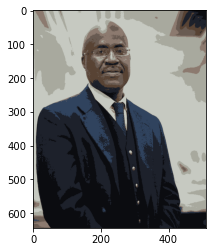

In [22]:
IP.imshow(I)

In [23]:
def getIdealCentroids(I, centroidDict):
    ''' Implement k-means algorithm on image initially with centroid of
        random but distinct colors.
        
        @param  I: original colored image
                centroidDict: intial chosen centroids (basically colors)
        
        @return hashmap of centroids (centroids = Color objects)
    '''
    l, w, numColors = I.shape
    
    changeInCentroids = True
    while (changeInCentroids):
        # iterate over the image and populate centroid dictionary
        for i in range(l):
            for j in range(w):
                # get color from pixel
                pixelColor = getColorFromPixel(I, (i, j))

                # populate hashmap with distances between colors based on RGB cube
                distances = {}
                for centroid in centroidDict:
                    if (centroid not in distances):
                        distances[centroid] = pixelColor.getDistance(centroid)

                # get centroid which has the lowest distance (aka color difference)
                minKey = getMinKey(distances)

                # add RGB color to centroid list
                centroidDict[minKey].append(pixelColor)

        # get mean of red, green, blue values separately and create new
        # color object with those values and update centroid values
        redSum = 0
        greenSum = 0
        blueSum = 0
        newDict = {}
        changeInCentroids = False
        for key in centroidDict:
            for color in centroidDict[key]:
                redSum += color.red
                greenSum += color.green
                blueSum += color.blue

            redSum /= len(centroidDict[key])
            greenSum /= len(centroidDict[key])
            blueSum /= len(centroidDict[key])

            # add new centroid to new dict
            newCentroid = Color(int(redSum), int(greenSum), int(blueSum))
            newDict[newCentroid] = []

            # update flag if new centroid is different from prev one
            if (key.getDistance(newCentroid) > 50):
                changeInCentroids = True

        # replace centroid dict with new one
        centroidDict = newDict
        
    return centroidDict

In [24]:
def quantizeImage(img, k):
    ''' Quantize a colored image by reducing the number of
        colors in the image to k colors.
        Essentially does so by implementing the k-means clustering
        algorithm on the image.
        
        @return color-quantized image
    '''
    
    I = IP.np.copy(img)
    l, w, numColors = I.shape
    
    # get k random colors from image
    colorsCentroid = chooseRandomColors(I, k)
    
    # create hashmap with centroids as keys and empty lists
    # list for a centroid will store the colors which have the minimum difference
    # with that centroid
    centroidDict = {}
    for c in colorsCentroid:
        centroidDict[c] = []
    
    centroidDict = getIdealCentroids(I, centroidDict)
    
    # update the colors in the image based on ideal centroids
    for i in range(l):
        for j in range(w):
            # get color from pixel
            pixelColor = getColorFromPixel(I, (i, j))

            # populate hashmap with distances between colors based RGB cube
            distances = {}
            for centroid in centroidDict:
                if (centroid not in distances):
                    distances[centroid] = pixelColor.getDistance(centroid)

            # get centroid which has the lowest distance (aka color difference)
            minKey = getMinKey(distances)

            # update colors 
            I[i, j, 0] = minKey.red
            I[i, j, 1] = minKey.green
            I[i, j, 2] = minKey.blue
            
    return I

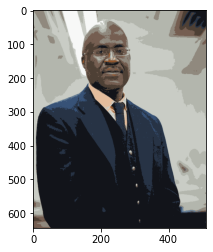

In [27]:
IP.imshow(quantizeImage(I, 12))

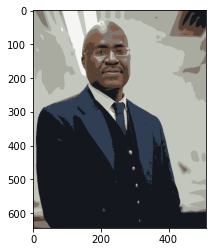

In [29]:
P=quantizeImage(I, 8)
IP.imshow(P)

In [30]:
def dilatedEdge(img,thresh):
    ''' Determines the edge of an image by dilating, and 
        binarizing the image.
        @param original image, binarizing threshold
        @output edge mask of image
    '''
    #using Top Hat
    strel=IP.square(3)
    dialate=IP.gs_imdilate(img,strel)
    eg=img-dialate
    out=1-IP.im2bw(IP.np.abs(eg),thresh)
    return out

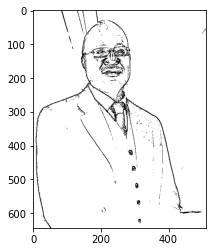

In [111]:
I2=IP.rgb2gray(I)
pp=dilatedEdge(I2,0.07)
IP.imshow(pp, cmap='gray')

In [112]:
#Converting gray scale to RGB
def gray2rgb(img,nchannels):
    IMG = IP.np.stack((img,)*3, axis=-1)
    return  IMG

In [113]:
pp1=gray2rgb(pp,3)

In [114]:
pp1.max()

1.0

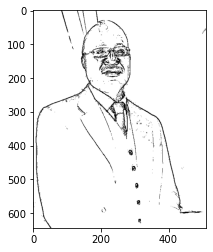

In [115]:
IP.imshow(pp1, cmap='gray')

In [116]:
pp2=pp1.astype(int)

In [117]:
add=pp2*P

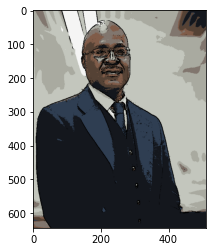

In [118]:
#add2=add.astype(IP.np.uint8)
IP.imshow(add)